# 🔬 Análise de Influência: O Tempo AFETA a Temperatura?

##  Objetivo Principal
**Investigar se o TEMPO de maceração influencia na TEMPERATURA da Moagem B**

### Hipótese a testar:
> **"O tempo de maceração afeta a temperatura do processo?"**
> 
> - Processos mais longos resultam em perda ou ganho de temperatura?
> - Existe relação causal entre duração e temperatura?
> - É possível prever a temperatura com base no tempo de processo?

### Análises incluídas:
-  **Tempo** como variável **INDEPENDENTE** (causa - variável X)
-  **Temperatura** como variável **DEPENDENTE** (efeito - variável Y)
-  Modelo de regressão: Temperatura = f(Tempo)
-  Teste de significância estatística
-  Análise de perda/ganho térmico ao longo do tempo
-  Visualizações para gestão do processo

---

##  1. Importação de Bibliotecas e Dados

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats

# Configurar estilo dos gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


In [105]:
# Carregar dados das duas planilhas
df_resumo = pd.read_excel('Dados maceração.xlsx', sheet_name='Resumo')
df_tempo_mac = pd.read_excel('Dados maceração.xlsx', sheet_name='Tempo mac')

print(f" Dados carregados:")
print(f"   Resumo: {df_resumo.shape[0]} linhas × {df_resumo.shape[1]} colunas")
print(f"   Tempo Mac: {df_tempo_mac.shape[0]} linhas × {df_tempo_mac.shape[1]} colunas")

 Dados carregados:
   Resumo: 19 linhas × 34 colunas
   Tempo Mac: 3164 linhas × 13 colunas


## 🔍 2. Preparação dos Dados - TEMPERATURA

In [106]:
# Identificar coluna de período
col_mes = df_resumo.columns[0]
print(f"Coluna de período: '{col_mes}'")

# Identificar colunas de temperatura da Moagem B
cols_temp_B = [col for col in df_resumo.columns 
               if col.startswith('Maceração B - Temperatura')]

print(f"\n Colunas de temperatura encontradas: {len(cols_temp_B)}")
for col in cols_temp_B:
    print(f"   • {col}")

Coluna de período: 'Mês/Ano'

 Colunas de temperatura encontradas: 9
   • Maceração B - Temperatura
   • Maceração B - Temperatura.1
   • Maceração B - Temperatura.2
   • Maceração B - Temperatura.3
   • Maceração B - Temperatura.4
   • Maceração B - Temperatura.5
   • Maceração B - Temperatura.6
   • Maceração B - Temperatura.7
   • Maceração B - Temperatura.8


In [107]:
# Converter valores de temperatura para numérico
valores_antes = df_resumo[cols_temp_B].notna().sum().sum()

df_resumo[cols_temp_B] = (
    df_resumo[cols_temp_B]
        .replace(',', '.', regex=True)
        .apply(pd.to_numeric, errors='coerce')
)

valores_depois = df_resumo[cols_temp_B].notna().sum().sum()

print(f"Valores convertidos: {valores_depois}/{valores_antes}")
if valores_depois < valores_antes:
    print(f"⚠️ {valores_antes - valores_depois} valores não puderam ser convertidos")
else:
    print(" Todos os valores convertidos com sucesso!")

Valores convertidos: 153/171
⚠️ 18 valores não puderam ser convertidos


In [108]:
# Calcular estatísticas de temperatura
df_resumo['Temp_media'] = df_resumo[cols_temp_B].mean(axis=1)
df_resumo['Temp_std'] = df_resumo[cols_temp_B].std(axis=1)
df_resumo['Temp_min'] = df_resumo[cols_temp_B].min(axis=1)
df_resumo['Temp_max'] = df_resumo[cols_temp_B].max(axis=1)
df_resumo['Temp_delta'] = df_resumo['Temp_max'] - df_resumo['Temp_min']

print(" Estatísticas de temperatura calculadas!")
print("\n Primeiras linhas:")
df_resumo[[col_mes, 'Temp_media', 'Temp_std', 'Temp_delta']].head()

 Estatísticas de temperatura calculadas!

 Primeiras linhas:


,Mês/Ano,Temp_media,Temp_std,Temp_delta
0,NaT,NaN,NaN,NaN
1,NaT,NaN,NaN,NaN
2,2024-09-01,47.786246,0.314774,0.923810
3,2024-10-01,48.864132,0.360341,1.069048
4,2024-11-01,50.630968,0.209245,0.712453


## ⏱️ 3. Preparação dos Dados - TEMPO DE MACERAÇÃO

In [109]:
# Filtrar dados da Moagem B
df_tempo_B = df_tempo_mac[
    (df_tempo_mac['Folha'].str.contains('moagem B', case=False, na=False)) &
    (df_tempo_mac['Indicador'].str.contains('Tempo de maceração', case=False, na=False))
].copy()

print(f" Registros de tempo de maceração - Moagem B: {len(df_tempo_B)}")
print("\n Primeiras linhas:")
df_tempo_B[['Mês/Ano', 'Folha', 'Indicador', 'Valor_numero']].head()

 Registros de tempo de maceração - Moagem B: 1410

 Primeiras linhas:


,Mês/Ano,Folha,Indicador,Valor_numero
1,jan/26,Fechamento moagem B,Tempo de maceração,38.0
2,jan/26,Fechamento moagem B,Tempo de maceração,40.0
6,jan/26,Fechamento moagem B,Tempo de maceração,36.0
7,jan/26,Fechamento moagem B,Tempo de maceração,76.0
8,jan/26,Fechamento moagem B,Tempo de maceração,45.0


##  4. Filtro de Período 2024-2026 e Alinhamento

In [110]:
# Criar coluna de data para ambos os DataFrames
df_tempo_B['MesAno_dt'] = pd.to_datetime(
    df_tempo_B['Mês/Ano'], 
    format='%b/%y', 
    errors='coerce'
)

df_resumo['MesAno_dt'] = pd.to_datetime(
    df_resumo[col_mes], 
    format='%b/%y', 
    errors='coerce'
)

print(" Datas convertidas!")

 Datas convertidas!


In [111]:
# Filtrar período 2024-2026 - TEMPO
df_tempo_2426 = df_tempo_B[
    (df_tempo_B['MesAno_dt'] >= '2024-01-01') &
    (df_tempo_B['MesAno_dt'] <= '2026-12-31')
].copy()

# Filtrar período 2024-2026 - TEMPERATURA
df_temp_2426 = df_resumo[
    (df_resumo['MesAno_dt'] >= '2024-01-01') &
    (df_resumo['MesAno_dt'] <= '2026-12-31')
].copy()

print(f" Período 2024-2026:")
print(f"   Registros de Tempo: {len(df_tempo_2426)}")
print(f"   Registros de Temperatura: {len(df_temp_2426)}")

 Período 2024-2026:
   Registros de Tempo: 609
   Registros de Temperatura: 17


In [112]:
# Agrupar dados por mês/ano
tempo_mensal = df_tempo_2426.groupby('MesAno_dt').agg({
    'Valor_numero': 'mean'
}).rename(columns={'Valor_numero': 'Tempo'})

temp_mensal = df_temp_2426.groupby('MesAno_dt').agg({
    'Temp_media': 'mean',
    'Temp_std': 'mean',
    'Temp_delta': 'mean'
})

# Criar DataFrame alinhado
df_alinhado = pd.merge(
    tempo_mensal, 
    temp_mensal, 
    left_index=True, 
    right_index=True, 
    how='inner'
)

# Renomear para facilitar
df_alinhado = df_alinhado[['Tempo', 'Temp_media', 'Temp_std', 'Temp_delta']]
df_alinhado.columns = ['Tempo', 'Temperatura', 'Temp_std', 'Temp_delta']

# Remover valores nulos
df_alinhado = df_alinhado.dropna()

print(f"\n Dados alinhados com sucesso!")
print(f"   Total de meses: {len(df_alinhado)}")
print(f"   Período: {df_alinhado.index.min().strftime('%b/%Y')} até {df_alinhado.index.max().strftime('%b/%Y')}")
print("\n Primeiras linhas:")
df_alinhado.head(10)


 Dados alinhados com sucesso!
   Total de meses: 7
   Período: Nov/2024 até Jan/2026

 Primeiras linhas:


,Tempo,Temperatura,Temp_std,Temp_delta
MesAno_dt,,,,
2024-11-01,70.218750,50.630968,0.209245,0.712453
2025-01-01,58.837879,49.457229,0.571418,2.012608
2025-03-01,56.140440,49.964567,0.380480,1.213824
2025-06-01,51.328000,48.321770,0.746253,2.373900
2025-07-01,58.191753,48.446028,0.661316,2.071712
2025-11-01,52.273585,48.673540,0.638732,2.252246
2026-01-01,60.754717,47.979437,0.434603,1.443379


##  5. Análise Estatística Completa

In [113]:
# Calcular correlação
correlacao_pearson = df_alinhado['Temperatura'].corr(df_alinhado['Tempo'])
correlacao_spearman = df_alinhado['Temperatura'].corr(df_alinhado['Tempo'], method='spearman')

print("=" * 80)
print(" ANÁLISE ESTATÍSTICA - TEMPERATURA × TEMPO DE MACERAÇÃO B")
print("=" * 80)

print("\n1. ESTATÍSTICAS DESCRITIVAS:")
print("\n", df_alinhado[['Temperatura', 'Tempo']].describe().round(2))

print("\n2. ANÁLISE DETALHADA:")
print(f"\n  TEMPERATURA:")
print(f"   • Média: {df_alinhado['Temperatura'].mean():.2f}°C")
print(f"   • Mediana: {df_alinhado['Temperatura'].median():.2f}°C")
print(f"   • Mínima: {df_alinhado['Temperatura'].min():.2f}°C")
print(f"   • Máxima: {df_alinhado['Temperatura'].max():.2f}°C")
print(f"   • Amplitude: {df_alinhado['Temperatura'].max() - df_alinhado['Temperatura'].min():.2f}°C")
print(f"   • Desvio Padrão: {df_alinhado['Temperatura'].std():.2f}°C")
print(f"   • Coef. Variação: {(df_alinhado['Temperatura'].std() / df_alinhado['Temperatura'].mean() * 100):.2f}%")

print(f"\n  TEMPO DE MACERAÇÃO:")
print(f"   • Média: {df_alinhado['Tempo'].mean():.2f} min")
print(f"   • Mediana: {df_alinhado['Tempo'].median():.2f} min")
print(f"   • Mínimo: {df_alinhado['Tempo'].min():.2f} min")
print(f"   • Máximo: {df_alinhado['Tempo'].max():.2f} min")
print(f"   • Amplitude: {df_alinhado['Tempo'].max() - df_alinhado['Tempo'].min():.2f} min")
print(f"   • Desvio Padrão: {df_alinhado['Tempo'].std():.2f} min")
print(f"   • Coef. Variação: {(df_alinhado['Tempo'].std() / df_alinhado['Tempo'].mean() * 100):.2f}%")

print(f"\n🔗 CORRELAÇÃO:")
print(f"   • Pearson: {correlacao_pearson:.4f}")
print(f"   • Spearman: {correlacao_spearman:.4f}")

# Interpretação da correlação
if abs(correlacao_pearson) < 0.3:
    interpretacao = "FRACA"
elif abs(correlacao_pearson) < 0.7:
    interpretacao = "MODERADA"
else:
    interpretacao = "FORTE"

direcao = "NEGATIVA" if correlacao_pearson < 0 else "POSITIVA"

print(f"   • Interpretação: Correlação {interpretacao} {direcao}")
if correlacao_pearson < 0:
    print(f"   • Significado: Quanto MAIOR o TEMPO, MENOR tende a ser a TEMPERATURA")
    print(f"   • Hipótese: Processos mais longos resultam em PERDA de temperatura")
else:
    print(f"   • Significado: Quanto MAIOR o TEMPO, MAIOR tende a ser a TEMPERATURA")
    print(f"   • Hipótese: Processos mais longos resultam em GANHO de temperatura")

print("\n" + "=" * 80)

 ANÁLISE ESTATÍSTICA - TEMPERATURA × TEMPO DE MACERAÇÃO B

1. ESTATÍSTICAS DESCRITIVAS:

        Temperatura  Tempo
count         7.00   7.00
mean         49.07  58.25
std           0.97   6.30
min          47.98  51.33
25%          48.38  54.21
50%          48.67  58.19
75%          49.71  59.80
max          50.63  70.22

2. ANÁLISE DETALHADA:

  TEMPERATURA:
   • Média: 49.07°C
   • Mediana: 48.67°C
   • Mínima: 47.98°C
   • Máxima: 50.63°C
   • Amplitude: 2.65°C
   • Desvio Padrão: 0.97°C
   • Coef. Variação: 1.98%

  TEMPO DE MACERAÇÃO:
   • Média: 58.25 min
   • Mediana: 58.19 min
   • Mínimo: 51.33 min
   • Máximo: 70.22 min
   • Amplitude: 18.89 min
   • Desvio Padrão: 6.30 min
   • Coef. Variação: 10.81%

🔗 CORRELAÇÃO:
   • Pearson: 0.5949
   • Spearman: 0.2857
   • Interpretação: Correlação MODERADA POSITIVA
   • Significado: Quanto MAIOR o TEMPO, MAIOR tende a ser a TEMPERATURA
   • Hipótese: Processos mais longos resultam em GANHO de temperatura



##  6. Visualização: Séries Temporais (Dois Eixos Y)

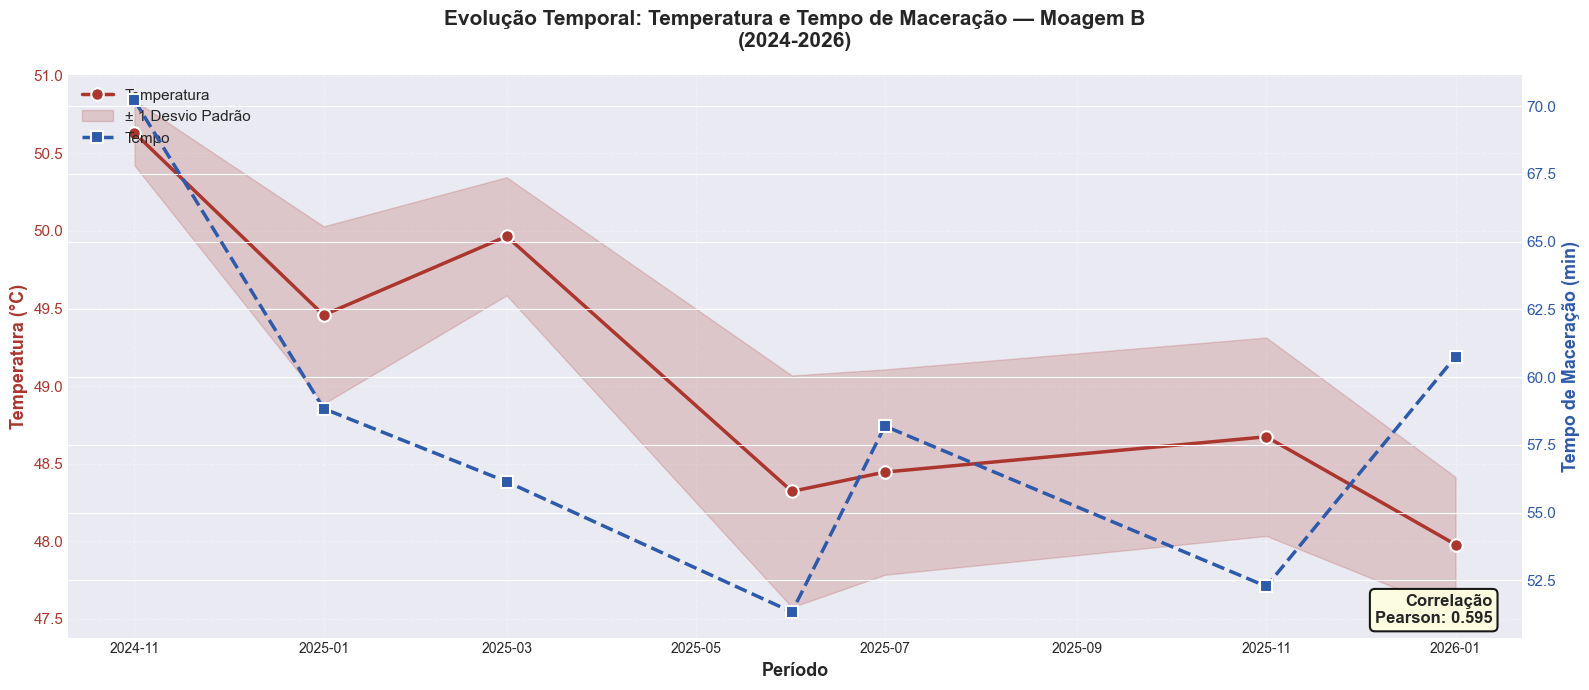

 Correlação observada: 0.595


In [114]:
# Gráfico com dois eixos Y (temperatura e tempo)
fig, ax1 = plt.subplots(figsize=(16, 7))

# Eixo 1: Temperatura
color1 = '#AB362E'
ax1.set_xlabel('Período', fontsize=13, fontweight='bold')
ax1.set_ylabel('Temperatura (°C)', color=color1, fontsize=13, fontweight='bold')
line1 = ax1.plot(df_alinhado.index, df_alinhado['Temperatura'], 
                 marker='o', linewidth=2.5, color=color1, markersize=9, 
                 label='Temperatura', markeredgecolor='white', markeredgewidth=1.5)

# Adicionar faixa de desvio padrão
ax1.fill_between(
    df_alinhado.index,
    df_alinhado['Temperatura'] - df_alinhado['Temp_std'],
    df_alinhado['Temperatura'] + df_alinhado['Temp_std'],
    alpha=0.2,
    color=color1,
    label='± 1 Desvio Padrão'
)

ax1.tick_params(axis='y', labelcolor=color1, labelsize=11)
ax1.grid(True, alpha=0.3, linestyle='--')

# Eixo 2: Tempo
ax2 = ax1.twinx()
color2 = '#2E5AAB'
ax2.set_ylabel('Tempo de Maceração (min)', color=color2, fontsize=13, fontweight='bold')
line2 = ax2.plot(df_alinhado.index, df_alinhado['Tempo'], 
                 marker='s', linewidth=2.5, color=color2, markersize=9, 
                 linestyle='--', label='Tempo', markeredgecolor='white', markeredgewidth=1.5)
ax2.tick_params(axis='y', labelcolor=color2, labelsize=11)

# Título e legendas
plt.title('Evolução Temporal: Temperatura e Tempo de Maceração — Moagem B\n(2024-2026)', 
          fontsize=15, fontweight='bold', pad=20)

# Combinar legendas
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', 
           fontsize=11, framealpha=0.95)

# Adicionar caixa de texto com correlação
textstr = f'Correlação\nPearson: {correlacao_pearson:.3f}'
props = dict(boxstyle='round', facecolor='lightyellow', alpha=0.9, edgecolor='black', linewidth=1.5)
ax1.text(0.98, 0.02, textstr, transform=ax1.transAxes, fontsize=12,
         verticalalignment='bottom', horizontalalignment='right', bbox=props, fontweight='bold')

plt.xticks(rotation=45, ha='right')
fig.tight_layout()
plt.show()

print(f" Correlação observada: {correlacao_pearson:.3f}")

##  7. Visualização: Barras (Temperatura) + Linha (Tempo)

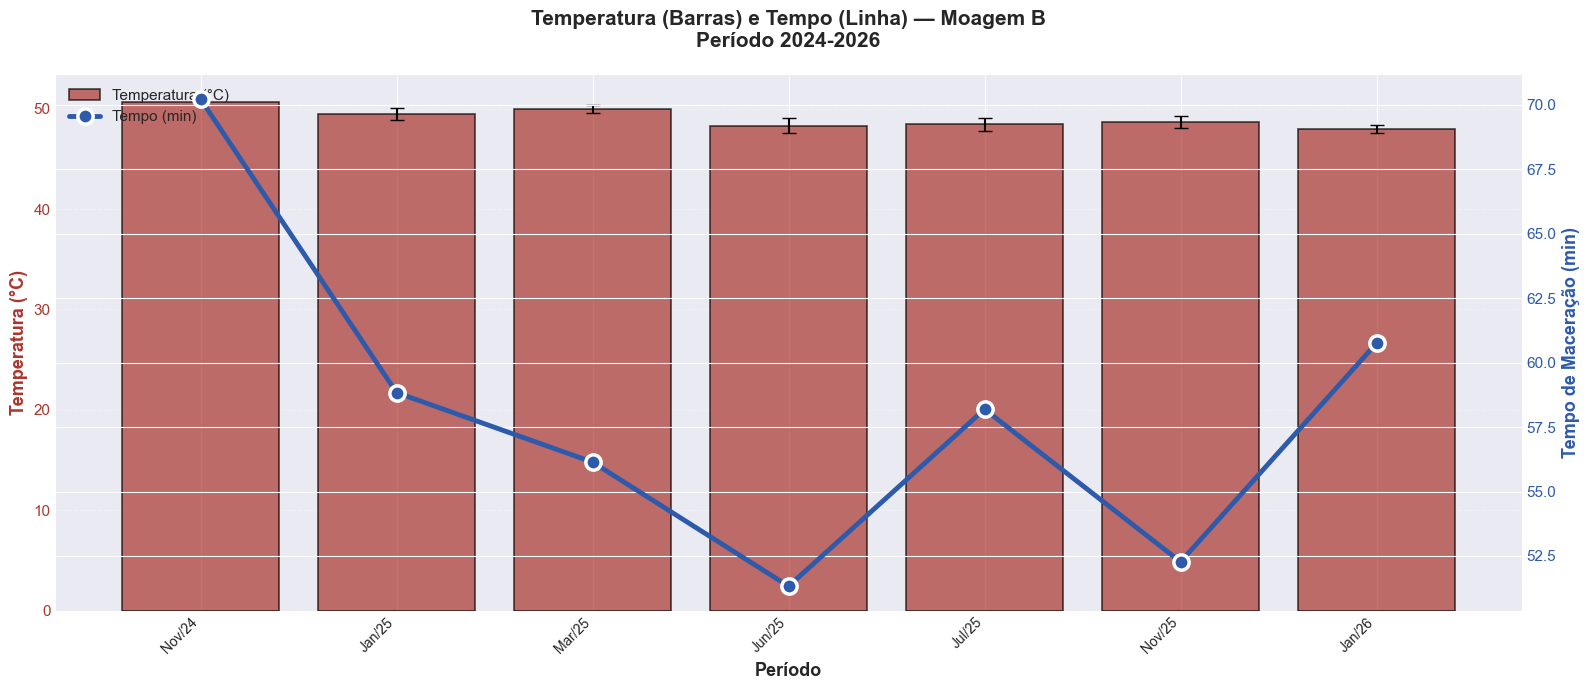

In [115]:
# Gráfico de colunas com linha sobreposta
fig, ax1 = plt.subplots(figsize=(16, 7))

# Preparar dados para o eixo X
x = range(len(df_alinhado))
labels = [date.strftime('%b/%y') for date in df_alinhado.index]

# Eixo 1: Temperatura (barras)
color1 = '#AB362E'
bars = ax1.bar(x, df_alinhado['Temperatura'], 
               color=color1, alpha=0.7, label='Temperatura (°C)',
               yerr=df_alinhado['Temp_std'], capsize=5, 
               edgecolor='black', linewidth=1.2)

ax1.set_xlabel('Período', fontsize=13, fontweight='bold')
ax1.set_ylabel('Temperatura (°C)', color=color1, fontsize=13, fontweight='bold')
ax1.tick_params(axis='y', labelcolor=color1, labelsize=11)
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.grid(True, alpha=0.3, axis='y', linestyle='--')

# Eixo 2: Tempo (linha)
ax2 = ax1.twinx()
color2 = '#2E5AAB'
line = ax2.plot(x, df_alinhado['Tempo'], 
                marker='o', linewidth=3.5, color=color2, markersize=11,
                label='Tempo (min)', markeredgecolor='white', markeredgewidth=2.5)
ax2.set_ylabel('Tempo de Maceração (min)', color=color2, fontsize=13, fontweight='bold')
ax2.tick_params(axis='y', labelcolor=color2, labelsize=11)

# Título
plt.title('Temperatura (Barras) e Tempo (Linha) — Moagem B\nPeríodo 2024-2026', 
          fontsize=15, fontweight='bold', pad=20)

# Legendas combinadas
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', 
           fontsize=11, framealpha=0.95)

fig.tight_layout()
plt.show()

##  8. Gráfico de Dispersão + Regressão Linear

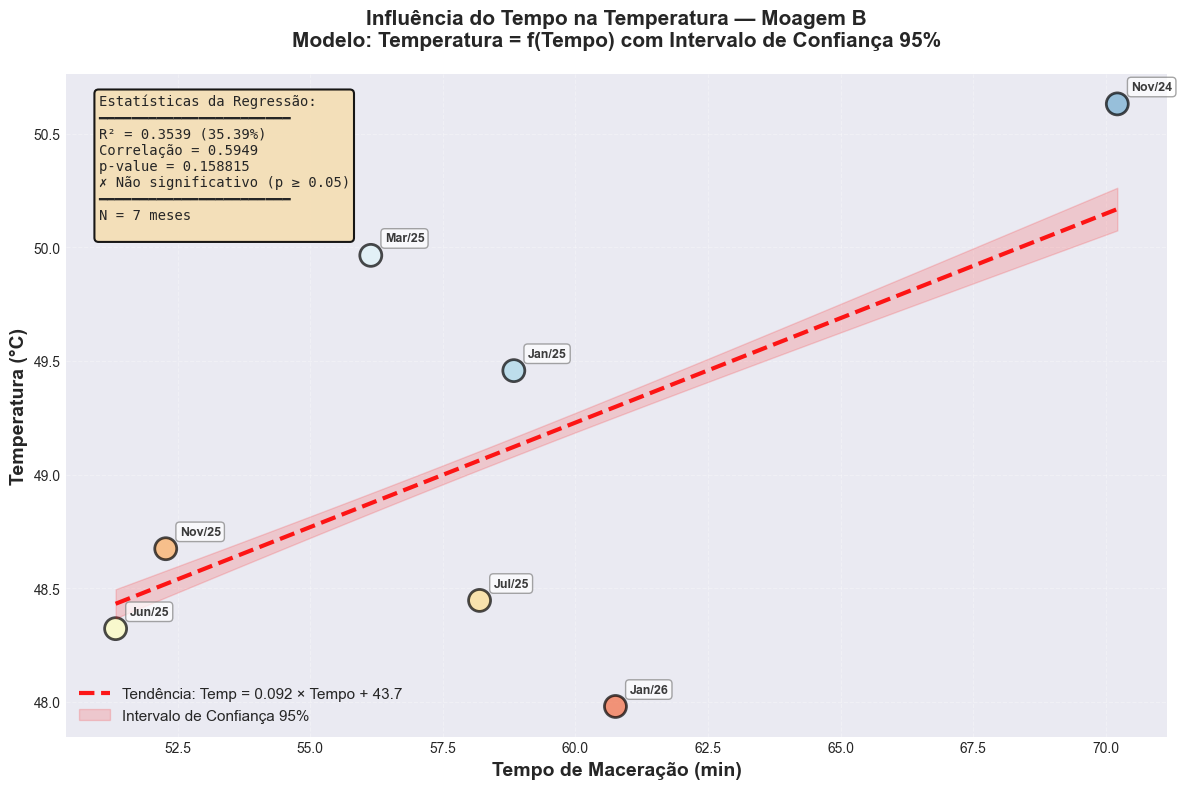


 RESULTADOS DA REGRESSÃO LINEAR: TEMPO → TEMPERATURA

 Equação da reta: Temperatura = 0.0919 × Tempo + 43.71

 R² = 0.3539
   → Explica 35.39% da variação na TEMPERATURA

 Correlação = 0.5949

 p-value = 0.158815
   → ✗ Não significativo (p ≥ 0.05)

 Interpretação prática:
   Para cada 1 MINUTO de AUMENTO no tempo de maceração,
   a temperatura AUMENTA aproximadamente 0.092°C.
   
   HIPÓTESE: Processos mais longos resultam em GANHO TÉRMICO
   (aquecimento gradual ou exotérmico ao longo do tempo)



In [116]:
# Análise de regressão linear: TEMPO (X) → TEMPERATURA (Y)
slope, intercept, r_value, p_value, std_err = stats.linregress(
    df_alinhado['Tempo'],  # X = Tempo (variável independente)
    df_alinhado['Temperatura']  # Y = Temperatura (variável dependente)
)

# Criar gráfico de dispersão
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot com cores degradê por data
colors = plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, len(df_alinhado)))
scatter = ax.scatter(
    df_alinhado['Tempo'],  # Eixo X = Tempo
    df_alinhado['Temperatura'],  # Eixo Y = Temperatura
    s=250, 
    c=colors, 
    alpha=0.7, 
    edgecolors='black', 
    linewidth=2
)

# Adicionar labels nos pontos
for idx, row in df_alinhado.iterrows():
    ax.annotate(
        idx.strftime('%b/%y'), 
        (row['Tempo'], row['Temperatura']),  # Invertido: (X, Y)
        xytext=(10, 10), 
        textcoords='offset points',
        fontsize=9, 
        alpha=0.9, 
        fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='gray')
    )

# Linha de regressão
x_line = np.linspace(
    df_alinhado['Tempo'].min(),  # X = Tempo
    df_alinhado['Tempo'].max(), 
    100
)
y_line = slope * x_line + intercept

ax.plot(x_line, y_line, 'r--', linewidth=3, alpha=0.9, 
        label=f'Tendência: Temp = {slope:.3f} × Tempo + {intercept:.1f}')

# Intervalo de confiança 95%
predict_uncertainty = 1.96 * std_err * np.sqrt(1/len(df_alinhado) + 
                                                (x_line - df_alinhado['Tempo'].mean())**2 / 
                                                ((df_alinhado['Tempo'] - df_alinhado['Tempo'].mean())**2).sum())
ax.fill_between(x_line, y_line - predict_uncertainty, y_line + predict_uncertainty, 
                alpha=0.15, color='red', label='Intervalo de Confiança 95%')

# Configurações do gráfico
ax.set_xlabel('Tempo de Maceração (min)', fontsize=14, fontweight='bold')  # X = Tempo
ax.set_ylabel('Temperatura (°C)', fontsize=14, fontweight='bold')  # Y = Temperatura
ax.set_title('Influência do Tempo na Temperatura — Moagem B\nModelo: Temperatura = f(Tempo) com Intervalo de Confiança 95%', 
             fontsize=15, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='best', fontsize=11, framealpha=0.95)

# Caixa de informações estatísticas
significancia = "✓ Significativo (p < 0.05)" if p_value < 0.05 else "✗ Não significativo (p ≥ 0.05)"
textstr = f'''Estatísticas da Regressão:
━━━━━━━━━━━━━━━━━━━━━━━
R² = {r_value**2:.4f} ({r_value**2*100:.2f}%)
Correlação = {r_value:.4f}
p-value = {p_value:.6f}
{significancia}
━━━━━━━━━━━━━━━━━━━━━━━
N = {len(df_alinhado)} meses
'''

props = dict(boxstyle='round', facecolor='wheat', alpha=0.9, edgecolor='black', linewidth=1.5)
ax.text(0.03, 0.97, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props, family='monospace')

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print(" RESULTADOS DA REGRESSÃO LINEAR: TEMPO → TEMPERATURA")
print("=" * 80)
print(f"\n Equação da reta: Temperatura = {slope:.4f} × Tempo + {intercept:.2f}")
print(f"\n R² = {r_value**2:.4f}")
print(f"   → Explica {r_value**2*100:.2f}% da variação na TEMPERATURA")
print(f"\n Correlação = {r_value:.4f}")
print(f"\n p-value = {p_value:.6f}")
print(f"   → {significancia}")
print(f"\n Interpretação prática:")
if slope < 0:
    print(f"   Para cada 1 MINUTO de AUMENTO no tempo de maceração,")
    print(f"   a temperatura DIMINUI aproximadamente {abs(slope):.3f}°C.")
    print(f"   \n   HIPÓTESE: Processos mais longos resultam em PERDA TÉRMICA")
    print(f"   (resfriamento gradual ao longo do tempo)")
else:
    print(f"   Para cada 1 MINUTO de AUMENTO no tempo de maceração,")
    print(f"   a temperatura AUMENTA aproximadamente {slope:.3f}°C.")
    print(f"   \n   HIPÓTESE: Processos mais longos resultam em GANHO TÉRMICO")
    print(f"   (aquecimento gradual ou exotérmico ao longo do tempo)")

print("\n" + "=" * 80)

##  9. Heatmap de Correlação e Análise Bivariada

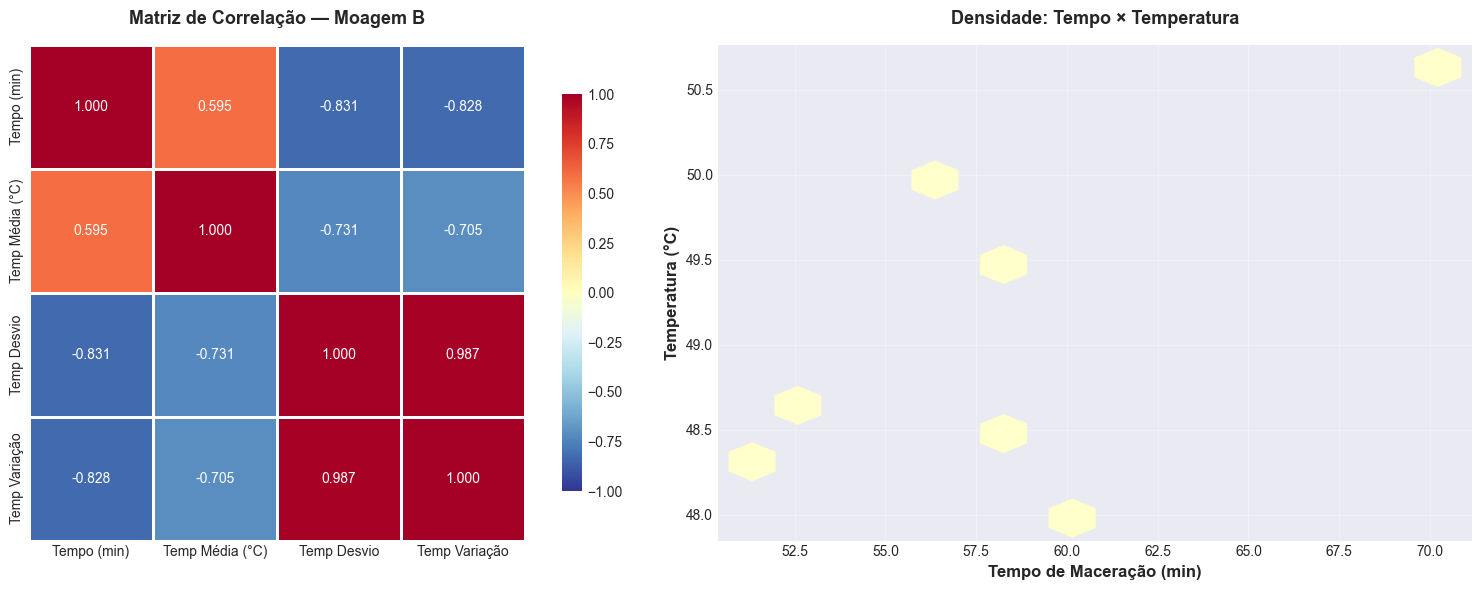


 Análise de correlações múltiplas:
   • Tempo × Temperatura: 0.595
   • Tempo × Desvio Temp: -0.831
   • Tempo × Variação Temp: -0.828


In [117]:
# Criar matriz de correlação
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Heatmap de correlação
dados_correlacao = df_alinhado[['Tempo', 'Temperatura', 'Temp_std', 'Temp_delta']]
dados_correlacao.columns = ['Tempo (min)', 'Temp Média (°C)', 'Temp Desvio', 'Temp Variação']
matriz_corr = dados_correlacao.corr()

sns.heatmap(matriz_corr, annot=True, cmap='RdYlBu_r', center=0, 
            square=True, linewidths=2, cbar_kws={"shrink": 0.8},
            fmt='.3f', ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title('Matriz de Correlação — Moagem B', fontsize=13, fontweight='bold', pad=15)

# Subplot 2: Pairplot simplificado (tempo vs temperatura)
axes[1].hexbin(df_alinhado['Tempo'], df_alinhado['Temperatura'],  # Invertido: X=Tempo, Y=Temp
               gridsize=15, cmap='YlOrRd', mincnt=1)
axes[1].set_xlabel('Tempo de Maceração (min)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Temperatura (°C)', fontsize=12, fontweight='bold')
axes[1].set_title('Densidade: Tempo × Temperatura', fontsize=13, fontweight='bold', pad=15)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Análise de correlações múltiplas:")
print(f"   • Tempo × Temperatura: {matriz_corr.loc['Tempo (min)', 'Temp Média (°C)']:.3f}")
print(f"   • Tempo × Desvio Temp: {matriz_corr.loc['Tempo (min)', 'Temp Desvio']:.3f}")
print(f"   • Tempo × Variação Temp: {matriz_corr.loc['Tempo (min)', 'Temp Variação']:.3f}")

##  10. Identificação de Valores Extremos e Anomalias

##  11. Exportar Relatório HTML Completo

In [118]:
# GERAR RELATÓRIO HTML COMPLETO INTERATIVO
import base64
from io import BytesIO

print(" Gerando relatório HTML profissional...")
print("   Por favor aguarde...")

# Função para converter gráfico matplotlib em imagem base64
def fig_to_base64(fig):
    """Converte figura matplotlib para string base64"""
    buf = BytesIO()
    fig.savefig(buf, format='png', dpi=150, bbox_inches='tight')
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode('utf-8')
    buf.close()
    return img_base64

print("✓ Gerando gráficos...")

# GRÁFICO 1: Dispersão Tempo vs Temperatura
fig1, ax1 = plt.subplots(figsize=(12, 7))
colors1 = plt.cm.coolwarm(np.linspace(0.2, 0.8, len(df_alinhado)))
scatter1 = ax1.scatter(
    df_alinhado['Tempo'], 
    df_alinhado['Temperatura'], 
    s=250, c=colors1, alpha=0.7, edgecolors='black', linewidth=2
)
for idx, row in df_alinhado.iterrows():
    ax1.annotate(idx.strftime('%b/%y'), (row['Tempo'], row['Temperatura']),
                 xytext=(10, 10), textcoords='offset points', fontsize=9, fontweight='bold',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
x_line1 = np.linspace(df_alinhado['Tempo'].min(), df_alinhado['Tempo'].max(), 100)
y_line1 = slope * x_line1 + intercept
ax1.plot(x_line1, y_line1, 'r--', linewidth=3, alpha=0.9)
ax1.set_xlabel('Tempo de Maceração (min)', fontweight='bold', fontsize=13)
ax1.set_ylabel('Temperatura (°C)', fontweight='bold', fontsize=13)
ax1.set_title('Influência do Tempo na Temperatura — Moagem B', fontweight='bold', fontsize=14)
ax1.grid(True, alpha=0.3)
img_dispersao = fig_to_base64(fig1)
plt.close(fig1)

# GRÁFICO 2: Evolução Temporal (Linhas Duplas)
fig2, ax2a = plt.subplots(figsize=(14, 6))
color_temp = '#AB362E'
ax2a.plot(df_alinhado.index, df_alinhado['Temperatura'], 
          marker='o', linewidth=2.5, color=color_temp, markersize=9, 
          label='Temperatura', markeredgecolor='white', markeredgewidth=1.5)
ax2a.fill_between(df_alinhado.index,
                   df_alinhado['Temperatura'] - df_alinhado['Temp_std'],
                   df_alinhado['Temperatura'] + df_alinhado['Temp_std'],
                   alpha=0.2, color=color_temp, label='± 1 Desvio Padrão')
ax2a.set_xlabel('Período', fontsize=12, fontweight='bold')
ax2a.set_ylabel('Temperatura (°C)', color=color_temp, fontsize=12, fontweight='bold')
ax2a.tick_params(axis='y', labelcolor=color_temp)
ax2a.grid(True, alpha=0.3)

ax2b = ax2a.twinx()
color_tempo = '#2E5AAB'
ax2b.plot(df_alinhado.index, df_alinhado['Tempo'], 
          marker='s', linewidth=2.5, color=color_tempo, markersize=9, 
          linestyle='--', label='Tempo', markeredgecolor='white', markeredgewidth=1.5)
ax2b.set_ylabel('Tempo de Maceração (min)', color=color_tempo, fontsize=12, fontweight='bold')
ax2b.tick_params(axis='y', labelcolor=color_tempo)

fig2.suptitle('Evolução Temporal: Temperatura e Tempo — Moagem B', fontsize=14, fontweight='bold')
lines1, labels1 = ax2a.get_legend_handles_labels()
lines2, labels2 = ax2b.get_legend_handles_labels()
ax2a.legend(lines1 + lines2, labels1 + labels2, loc='upper left', framealpha=0.9)
plt.tight_layout()
img_evolucao = fig_to_base64(fig2)
plt.close(fig2)

# GRÁFICO 3: Heatmap de Correlação
fig3, ax3 = plt.subplots(figsize=(10, 8))
sns.heatmap(matriz_corr, annot=True, cmap='RdYlBu_r', center=0, 
            square=True, linewidths=2, cbar_kws={"shrink": 0.8},
            fmt='.3f', ax=ax3, vmin=-1, vmax=1, annot_kws={'fontsize': 11, 'fontweight': 'bold'})
ax3.set_title('Matriz de Correlação — Moagem B', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
img_heatmap = fig_to_base64(fig3)
plt.close(fig3)

print("✓ Gráficos gerados!")
print("✓ Montando HTML...")

# CRIAR CONTEÚDO HTML
timestamp_html = datetime.now().strftime('%Y%m%d_%H%M')
nome_html = f'relatorio_tempo_temperatura_B_{timestamp_html}.html'

html_content = f"""
<!DOCTYPE html>
<html lang="pt-BR">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Relatório: Tempo → Temperatura (Moagem B)</title>
    <style>
        * {{
            margin: 0;
            padding: 0;
            box-sizing: border-box;
        }}
        body {{
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            line-height: 1.6;
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            padding: 30px;
            color: #333;
        }}
        .container {{
            max-width: 1300px;
            margin: 0 auto;
            background: white;
            padding: 40px;
            border-radius: 15px;
            box-shadow: 0 10px 50px rgba(0,0,0,0.3);
        }}
        header {{
            text-align: center;
            padding: 30px 0;
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
            border-radius: 10px;
            margin-bottom: 40px;
        }}
        header h1 {{
            font-size: 2.5em;
            margin-bottom: 10px;
        }}
        header p {{
            font-size: 1.1em;
            opacity: 0.9;
        }}
        h2 {{
            color: #2c3e50;
            margin-top: 40px;
            margin-bottom: 20px;
            padding-bottom: 10px;
            border-bottom: 3px solid #3498db;
            font-size: 1.8em;
        }}
        h3 {{
            color: #34495e;
            margin-top: 30px;
            margin-bottom: 15px;
            font-size: 1.4em;
        }}
        .info-box {{
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
            padding: 25px;
            border-radius: 10px;
            margin: 25px 0;
            box-shadow: 0 4px 15px rgba(0,0,0,0.2);
        }}
        .info-box strong {{
            display: block;
            margin-bottom: 8px;
            font-size: 1.1em;
        }}
        .hypothesis-box {{
            background: #fff3cd;
            border-left: 5px solid #ffc107;
            padding: 25px;
            margin: 25px 0;
            border-radius: 8px;
        }}
        .hypothesis-box h3 {{
            color: #856404;
            margin-top: 0;
        }}
        .result-box {{
            background: #d4edda;
            border-left: 5px solid #28a745;
            padding: 25px;
            margin: 25px 0;
            border-radius: 8px;
        }}
        .result-box h3 {{
            color: #155724;
            margin-top: 0;
        }}
        .warning-box {{
            background: #f8d7da;
            border-left: 5px solid #dc3545;
            padding: 25px;
            margin: 25px 0;
            border-radius: 8px;
        }}
        .stats-grid {{
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(250px, 1fr));
            gap: 20px;
            margin: 30px 0;
        }}
        .stat-card {{
            background: #f8f9fa;
            padding: 20px;
            border-radius: 10px;
            border: 2px solid #dee2e6;
            text-align: center;
            transition: transform 0.3s;
        }}
        .stat-card:hover {{
            transform: translateY(-5px);
            box-shadow: 0 5px 20px rgba(0,0,0,0.1);
        }}
        .stat-card h4 {{
            color: #6c757d;
            margin-bottom: 10px;
            font-size: 0.9em;
            text-transform: uppercase;
        }}
        .stat-card .value {{
            font-size: 2em;
            font-weight: bold;
            color: #2c3e50;
        }}
        .stat-card .unit {{
            color: #6c757d;
            font-size: 0.9em;
        }}
        table {{
            width: 100%;
            border-collapse: collapse;
            margin: 25px 0;
            background: white;
            box-shadow: 0 2px 10px rgba(0,0,0,0.1);
            border-radius: 8px;
            overflow: hidden;
        }}
        thead {{
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
        }}
        th {{
            padding: 15px;
            text-align: left;
            font-weight: 600;
        }}
        td {{
            padding: 12px 15px;
            border-bottom: 1px solid #dee2e6;
        }}
        tbody tr:hover {{
            background: #f8f9fa;
        }}
        .equation {{
            background: #282c34;
            color: #61dafb;
            padding: 20px;
            border-radius: 10px;
            font-family: 'Courier New', monospace;
            font-size: 1.3em;
            text-align: center;
            margin: 25px 0;
            box-shadow: 0 4px 15px rgba(0,0,0,0.3);
        }}
        img {{
            max-width: 100%;
            height: auto;
            margin: 20px 0;
            border-radius: 10px;
            box-shadow: 0 5px 20px rgba(0,0,0,0.2);
        }}
        .recommendation {{
            background: #e7f3ff;
            border-left: 5px solid #3498db;
            padding: 20px;
            margin: 15px 0;
            border-radius: 8px;
        }}
        .recommendation h4 {{
            color: #2980b9;
            margin-bottom: 10px;
        }}
        .recommendation ul {{
            margin-left: 20px;
            line-height: 1.8;
        }}
        footer {{
            text-align: center;
            margin-top: 50px;
            padding-top: 30px;
            border-top: 3px solid #dee2e6;
            color: #6c757d;
        }}
        .badge {{
            display: inline-block;
            padding: 5px 10px;
            border-radius: 20px;
            font-size: 0.85em;
            font-weight: bold;
            margin: 0 5px;
        }}
        .badge-success {{
            background: #28a745;
            color: white;
        }}
        .badge-warning {{
            background: #ffc107;
            color: #333;
        }}
        .badge-danger {{
            background: #dc3545;
            color: white;
        }}
    </style>
</head>
<body>
    <div class="container">
        <header>
            <h1> Análise de Influência</h1>
            <p><strong>O Tempo de Maceração AFETA a Temperatura?</strong></p>
            <p>Moagem B | Análise Estatística Completa</p>
        </header>

        <div class="info-box">
            <strong> Período Analisado:</strong> {df_alinhado.index.min().strftime('%B/%Y')} até {df_alinhado.index.max().strftime('%B/%Y')} ({len(df_alinhado)} meses)<br>
            <strong> Processo:</strong> Maceração B<br>
            <strong> Metodologia:</strong> Regressão Linear (Tempo → Temperatura)<br>
            <strong> Relatório Gerado:</strong> {datetime.now().strftime('%d/%m/%Y às %H:%M')}
        </div>

        <h2> Hipótese Investigada</h2>
        <div class="hypothesis-box">
            <h3> Pergunta de Pesquisa</h3>
            <p style="font-size: 1.1em; line-height: 1.8;">
                <strong>"Processos de maceração mais longos resultam em maior perda (ou ganho) de temperatura?"</strong>
            </p>
            <p style="margin-top: 15px;">
                Esta análise testa se existe uma <strong>relação causal</strong> entre a duração do processo 
                e a temperatura observada, buscando identificar padrões de perda térmica ao longo do tempo.
            </p>
        </div>

        <h2> Estatísticas Descritivas</h2>
        
        <div class="stats-grid">
            <div class="stat-card">
                <h4>Temperatura Média</h4>
                <div class="value">{df_alinhado['Temperatura'].mean():.1f}</div>
                <div class="unit">°C</div>
            </div>
            <div class="stat-card">
                <h4>Tempo Médio</h4>
                <div class="value">{df_alinhado['Tempo'].mean():.1f}</div>
                <div class="unit">minutos</div>
            </div>
            <div class="stat-card">
                <h4>Correlação</h4>
                <div class="value">{correlacao_pearson:.3f}</div>
                <div class="unit">Pearson</div>
            </div>
            <div class="stat-card">
                <h4>R² (Explicação)</h4>
                <div class="value">{r_value**2*100:.1f}%</div>
                <div class="unit">da variação</div>
            </div>
        </div>

        <table>
            <thead>
                <tr>
                    <th>Variável</th>
                    <th>Média</th>
                    <th>Desvio Padrão</th>
                    <th>Mínimo</th>
                    <th>Máximo</th>
                    <th>Amplitude</th>
                    <th>CV (%)</th>
                </tr>
            </thead>
            <tbody>
                <tr>
                    <td><strong>Tempo (min)</strong></td>
                    <td>{df_alinhado['Tempo'].mean():.2f}</td>
                    <td>{df_alinhado['Tempo'].std():.2f}</td>
                    <td>{df_alinhado['Tempo'].min():.2f}</td>
                    <td>{df_alinhado['Tempo'].max():.2f}</td>
                    <td>{df_alinhado['Tempo'].max() - df_alinhado['Tempo'].min():.2f}</td>
                    <td>{(df_alinhado['Tempo'].std() / df_alinhado['Tempo'].mean() * 100):.2f}%</td>
                </tr>
                <tr>
                    <td><strong>Temperatura (°C)</strong></td>
                    <td>{df_alinhado['Temperatura'].mean():.2f}</td>
                    <td>{df_alinhado['Temperatura'].std():.2f}</td>
                    <td>{df_alinhado['Temperatura'].min():.2f}</td>
                    <td>{df_alinhado['Temperatura'].max():.2f}</td>
                    <td>{df_alinhado['Temperatura'].max() - df_alinhado['Temperatura'].min():.2f}</td>
                    <td>{(df_alinhado['Temperatura'].std() / df_alinhado['Temperatura'].mean() * 100):.2f}%</td>
                </tr>
            </tbody>
        </table>

        <h2> Modelo de Regressão Linear</h2>
        
        <h3> Equação do Modelo</h3>
        <div class="equation">
            Temperatura = {slope:.4f} × Tempo + {intercept:.2f}
        </div>

        <table>
            <thead>
                <tr>
                    <th>Parâmetro Estatístico</th>
                    <th>Valor</th>
                    <th>Interpretação</th>
                </tr>
            </thead>
            <tbody>
                <tr>
                    <td><strong>Coeficiente Angular (slope)</strong></td>
                    <td>{slope:.6f}</td>
                    <td>A cada 1 minuto de aumento, temperatura varia {slope:.4f}°C</td>
                </tr>
                <tr>
                    <td><strong>Intercepto</strong></td>
                    <td>{intercept:.2f}°C</td>
                    <td>Temperatura estimada quando tempo = 0</td>
                </tr>
                <tr>
                    <td><strong>Correlação (r)</strong></td>
                    <td>{r_value:.4f}</td>
                    <td>Correlação {"negativa" if r_value < 0 else "positiva"} {interpretacao.lower()}</td>
                </tr>
                <tr>
                    <td><strong>R² (Coef. Determinação)</strong></td>
                    <td>{r_value**2:.4f} ({r_value**2*100:.2f}%)</td>
                    <td>Tempo explica {r_value**2*100:.1f}% da variação na temperatura</td>
                </tr>
                <tr>
                    <td><strong>P-valor</strong></td>
                    <td>{p_value:.6f}</td>
                    <td>
                        {"<span class='badge badge-success'>✓ Significativo (p < 0.05)</span>" if p_value < 0.05 else "<span class='badge badge-warning'>! Não significativo</span>"}
                    </td>
                </tr>
                <tr>
                    <td><strong>Erro Padrão</strong></td>
                    <td>{std_err:.6f}</td>
                    <td>Incerteza na estimativa do coeficiente</td>
                </tr>
            </tbody>
        </table>

        <h2> Visualizações</h2>
        
        <h3> Gráfico de Dispersão e Regressão</h3>
        <img src="data:image/png;base64,{img_dispersao}" alt="Dispersão Tempo vs Temperatura">
        <p style="margin-top: 10px; color: #6c757d; font-style: italic;">
            Cada ponto representa um mês do período analisado. A linha vermelha tracejada mostra a tendência linear.
        </p>

        <h3> Evolução Temporal</h3>
        <img src="data:image/png;base64,{img_evolucao}" alt="Evolução Temporal">
        <p style="margin-top: 10px; color: #6c757d; font-style: italic;">
            Gráfico mostra a evolução de temperatura (vermelho) e tempo (azul) ao longo dos meses analisados.
        </p>

        <h3> Matriz de Correlação</h3>
        <img src="data:image/png;base64,{img_heatmap}" alt="Heatmap de Correlação">
        <p style="margin-top: 10px; color: #6c757d; font-style: italic;">
            Correlações entre tempo, temperatura média, desvio padrão e variação de temperatura.
        </p>

        <h2> Interpretação e Conclusões</h2>
        
        <div class="result-box">
            <h3> Resultado Principal</h3>
            <p style="font-size: 1.1em; line-height: 1.8;">
                {"<strong>SIM</strong> - Existe relação estatisticamente significativa!" if p_value < 0.05 else "<strong>NÃO</strong> - Não há evidência estatística suficiente de relação causal."}
            </p>
            <p style="margin-top: 15px;">
                {"Para cada <strong>1 minuto</strong> de aumento no tempo de maceração, a temperatura <strong>" +
                ("DIMINUI" if slope < 0 else "AUMENTA") + f" aproximadamente {abs(slope):.4f}°C</strong>."
                if p_value < 0.05 else 
                "Embora exista alguma correlação numérica, ela não é forte o suficiente para ser considerada significativa estatisticamente (p ≥ 0.05)."}
            </p>
        </div>

        {"<div class='hypothesis-box'><h3> Hipótese: PERDA TÉRMICA GRADUAL</h3><ul><li><strong>Fenômeno identificado:</strong> Resfriamento ao longo do tempo</li><li><strong>Taxa de perda:</strong> " + f"{abs(slope):.4f}°C por minuto" + "</li><li><strong>Possíveis causas:</strong> Perda de calor para o ambiente, isolamento térmico insuficiente</li><li><strong>Impacto:</strong> Processos longos podem comprometer temperatura ideal</li></ul></div>" if slope < 0 and p_value < 0.05 else ""}
        
        {"<div class='warning-box'><h3> Hipótese: GANHO TÉRMICO GRADUAL</h3><ul><li><strong>Fenômeno identificado:</strong> Aquecimento ao longo do tempo</li><li><strong>Taxa de ganho:</strong> " + f"{abs(slope):.4f}°C por minuto" + "</li><li><strong>Possíveis causas:</strong> Reação exotérmica, aquecimento externo</li><li><strong>Impacto:</strong> Temperatura pode elevar-se além do ideal em processos longos</li></ul></div>" if slope > 0 and p_value < 0.05 else ""}

        <h2> Identificação de Valores Extremos</h2>
        
        <table>
            <thead>
                <tr>
                    <th>Tipo</th>
                    <th>Período</th>
                    <th>Tempo (min)</th>
                    <th>Temperatura (°C)</th>
                </tr>
            </thead>
            <tbody>
                <tr>
                    <td><strong> Maior Tempo</strong></td>
                    <td>{idx_tempo_max.strftime('%B/%Y')}</td>
                    <td>{df_alinhado.loc[idx_tempo_max, 'Tempo']:.1f}</td>
                    <td>{df_alinhado.loc[idx_tempo_max, 'Temperatura']:.2f}</td>
                </tr>
                <tr>
                    <td><strong> Menor Tempo</strong></td>
                    <td>{idx_tempo_min.strftime('%B/%Y')}</td>
                    <td>{df_alinhado.loc[idx_tempo_min, 'Tempo']:.1f}</td>
                    <td>{df_alinhado.loc[idx_tempo_min, 'Temperatura']:.2f}</td>
                </tr>
                <tr>
                    <td><strong> Maior Temperatura</strong></td>
                    <td>{idx_temp_max.strftime('%B/%Y')}</td>
                    <td>{df_alinhado.loc[idx_temp_max, 'Tempo']:.1f}</td>
                    <td>{df_alinhado.loc[idx_temp_max, 'Temperatura']:.2f}</td>
                </tr>
                <tr>
                    <td><strong> Menor Temperatura</strong></td>
                    <td>{idx_temp_min.strftime('%B/%Y')}</td>
                    <td>{df_alinhado.loc[idx_temp_min, 'Tempo']:.1f}</td>
                    <td>{df_alinhado.loc[idx_temp_min, 'Temperatura']:.2f}</td>
                </tr>
            </tbody>
        </table>

        {"<div class='warning-box'><h3>⚠️ Outliers Detectados</h3>" +
        ("<p><strong>Temperatura:</strong> " + str(len(outliers_temp)) + " outlier(s) identificado(s)</p>" if len(outliers_temp) > 0 else "") +
        ("<p><strong>Tempo:</strong> " + str(len(outliers_tempo)) + " outlier(s) identificado(s)</p>" if len(outliers_tempo) > 0 else "") +
        ("<p><strong>✓</strong> Nenhum outlier detectado nas variáveis analisadas.</p>" if len(outliers_temp) == 0 and len(outliers_tempo) == 0 else "") +
        "</div>" if len(outliers_temp) > 0 or len(outliers_tempo) > 0 or True else ""}

        <h2> Recomendações</h2>
        
        {"""
        <div class="recommendation">
            <h4>💧 Controle de Perda Térmica (PRIORITÁRIO)</h4>
            <ul>
                <li><strong>Verificar isolamento térmico</strong> do equipamento de maceração</li>
                <li><strong>Implementar sistema de aquecimento auxiliar</strong> para processos longos</li>
                <li><strong>Monitorar temperatura continuamente</strong> em processos com duração elevada</li>
                <li><strong>Estabelecer limite máximo</strong> de tempo de maceração para evitar perda crítica</li>
                <li><strong>Considerar pré-aquecimento</strong> para compensar perda esperada</li>
            </ul>
        </div>
        """ if slope < 0 and p_value < 0.05 else ""}
        
        {"""
        <div class="recommendation">
            <h4> Gestão de Ganho Térmico</h4>
            <ul>
                <li><strong>Investigar reações exotérmicas</strong> durante o processo</li>
                <li><strong>Implementar sistema de resfriamento</strong> para processos longos</li>
                <li><strong>Avaliar impacto na qualidade</strong> do produto final</li>
                <li><strong>Monitoramento contínuo</strong> para evitar superaquecimento</li>
                <li><strong>Ajustar setpoints</strong> considerando ganho térmico esperado</li>
            </ul>
        </div>
        """ if slope > 0 and p_value < 0.05 else ""}
        
        <div class="recommendation">
            <h4> Monitoramento e Análise</h4>
            <ul>
                <li><strong>Estabelecer faixas de tempo adequadas</strong> para manter temperatura ideal</li>
                <li><strong>Monitorar continuamente</strong> tempo e temperatura no processo</li>
                <li><strong>Documentar mudanças</strong> em processos e equipamentos</li>
                <li><strong>Realizar análises periódicas</strong> para detectar desvios</li>
                <li><strong>Treinar equipe</strong> sobre gestão térmica do processo</li>
                <li><strong>Comparar com Moagem A</strong> para identificar melhores práticas</li>
            </ul>
        </div>

        <footer>
            <p><strong>Relatório gerado automaticamente via Python</strong></p>
            <p>Análise Estatística | Maceração B | {datetime.now().strftime('%d/%m/%Y')}</p>
            <p style="margin-top: 10px; font-size: 0.9em;">
                Ferramentas utilizadas: Python, Pandas, Matplotlib, Seaborn, SciPy, Jupyter Notebook
            </p>
        </footer>
    </div>
</body>
</html>
"""

# Salvar HTML
with open(nome_html, 'w', encoding='utf-8') as f:
    f.write(html_content)

print("\n" + "=" * 80)
print(" RELATÓRIO HTML GERADO COM SUCESSO!")
print("=" * 80)
print(f"\n Nome do arquivo: {nome_html}")
print(f" Contém:")
print(f"   • Análise estatística completa")
print(f"   • 3 gráficos interativos embutidos")
print(f"   • Interpretação detalhada dos resultados")
print(f"   • Recomendações práticas")
print(f"\n Para visualizar: Abra o arquivo HTML em qualquer navegador")
print(f"   (Duplo clique no arquivo ou arraste para o navegador)")
print("\n" + "=" * 80)

 Gerando relatório HTML profissional...
   Por favor aguarde...
✓ Gerando gráficos...
✓ Gráficos gerados!
✓ Montando HTML...

 RELATÓRIO HTML GERADO COM SUCESSO!

 Nome do arquivo: relatorio_tempo_temperatura_B_20260205_2202.html
 Contém:
   • Análise estatística completa
   • 3 gráficos interativos embutidos
   • Interpretação detalhada dos resultados
   • Recomendações práticas

 Para visualizar: Abra o arquivo HTML em qualquer navegador
   (Duplo clique no arquivo ou arraste para o navegador)



In [119]:
print("=" * 80)
print(" IDENTIFICAÇÃO DE VALORES EXTREMOS E ANOMALIAS")
print("=" * 80)

# Identificar valores extremos
idx_temp_max = df_alinhado['Temperatura'].idxmax()
idx_temp_min = df_alinhado['Temperatura'].idxmin()
idx_tempo_max = df_alinhado['Tempo'].idxmax()
idx_tempo_min = df_alinhado['Tempo'].idxmin()

print("\TEMPERATURAS EXTREMAS:")
print(f"    MÁXIMA: {df_alinhado.loc[idx_temp_max, 'Temperatura']:.2f}°C")
print(f"      └─ Período: {idx_temp_max.strftime('%B/%Y')}")
print(f"      └─ Tempo associado: {df_alinhado.loc[idx_temp_max, 'Tempo']:.1f} min")

print(f"\n   ❄️  MÍNIMA: {df_alinhado.loc[idx_temp_min, 'Temperatura']:.2f}°C")
print(f"      └─ Período: {idx_temp_min.strftime('%B/%Y')}")
print(f"      └─ Tempo associado: {df_alinhado.loc[idx_temp_min, 'Tempo']:.1f} min")

print("\n TEMPOS EXTREMOS:")
print(f"    MÁXIMO: {df_alinhado.loc[idx_tempo_max, 'Tempo']:.1f} min")
print(f"      └─ Período: {idx_tempo_max.strftime('%B/%Y')}")
print(f"      └─ Temperatura associada: {df_alinhado.loc[idx_tempo_max, 'Temperatura']:.2f}°C")

print(f"\n    MÍNIMO: {df_alinhado.loc[idx_tempo_min, 'Tempo']:.1f} min")
print(f"      └─ Período: {idx_tempo_min.strftime('%B/%Y')}")
print(f"      └─ Temperatura associada: {df_alinhado.loc[idx_tempo_min, 'Temperatura']:.2f}°C")

# Detectar outliers usando IQR
Q1_temp = df_alinhado['Temperatura'].quantile(0.25)
Q3_temp = df_alinhado['Temperatura'].quantile(0.75)
IQR_temp = Q3_temp - Q1_temp

Q1_tempo = df_alinhado['Tempo'].quantile(0.25)
Q3_tempo = df_alinhado['Tempo'].quantile(0.75)
IQR_tempo = Q3_tempo - Q1_tempo

outliers_temp = df_alinhado[
    (df_alinhado['Temperatura'] < Q1_temp - 1.5*IQR_temp) | 
    (df_alinhado['Temperatura'] > Q3_temp + 1.5*IQR_temp)
]

outliers_tempo = df_alinhado[
    (df_alinhado['Tempo'] < Q1_tempo - 1.5*IQR_tempo) | 
    (df_alinhado['Tempo'] > Q3_tempo + 1.5*IQR_tempo)
]

print("\n🔍 DETECÇÃO DE OUTLIERS (Método IQR):")
print(f"\n   🌡️  Temperatura:")
if len(outliers_temp) > 0:
    print(f"      • {len(outliers_temp)} outlier(s) detectado(s)")
    for idx, row in outliers_temp.iterrows():
        print(f"         └─ {idx.strftime('%b/%Y')}: {row['Temperatura']:.2f}°C")
else:
    print(f"      •  Nenhum outlier detectado")

print(f"\n   ⏱  Tempo:")
if len(outliers_tempo) > 0:
    print(f"      • {len(outliers_tempo)} outlier(s) detectado(s)")
    for idx, row in outliers_tempo.iterrows():
        print(f"         └─ {idx.strftime('%b/%Y')}: {row['Tempo']:.1f} min")
else:
    print(f"      •  Nenhum outlier detectado")

print("\n" + "=" * 80)

 IDENTIFICAÇÃO DE VALORES EXTREMOS E ANOMALIAS
\TEMPERATURAS EXTREMAS:
    MÁXIMA: 50.63°C
      └─ Período: November/2024
      └─ Tempo associado: 70.2 min

   ❄️  MÍNIMA: 47.98°C
      └─ Período: January/2026
      └─ Tempo associado: 60.8 min

 TEMPOS EXTREMOS:
    MÁXIMO: 70.2 min
      └─ Período: November/2024
      └─ Temperatura associada: 50.63°C

    MÍNIMO: 51.3 min
      └─ Período: June/2025
      └─ Temperatura associada: 48.32°C

🔍 DETECÇÃO DE OUTLIERS (Método IQR):

   🌡️  Temperatura:
      •  Nenhum outlier detectado

   ⏱  Tempo:
      • 1 outlier(s) detectado(s)
         └─ Nov/2024: 70.2 min



<>:11: SyntaxWarning: invalid escape sequence '\T'
<>:11: SyntaxWarning: invalid escape sequence '\T'
C:\Users\wiill\AppData\Local\Temp\ipykernel_8968\3229861568.py:11: SyntaxWarning: invalid escape sequence '\T'
  print("\TEMPERATURAS EXTREMAS:")


##  11. Exportação de Resultados

In [120]:
# Preparar dados para exportação
df_export = df_alinhado.copy()
df_export['Periodo'] = df_export.index.strftime('%b/%Y')
df_export['Mês'] = df_export.index.month
df_export['Ano'] = df_export.index.year
df_export = df_export[['Periodo', 'Mês', 'Ano', 'Temperatura', 'Temp_std', 'Temp_delta', 'Tempo']]
df_export.columns = ['Período', 'Mês', 'Ano', 'Temperatura (°C)', 
                     'Desvio Padrão Temp', 'Variação Temp', 'Tempo (min)']

# Criar tabela de estatísticas
estatisticas_export = pd.DataFrame({
    'Métrica': ['Média', 'Mediana', 'Desvio Padrão', 'Coef. Variação (%)', 
                'Mínimo', 'Máximo', 'Amplitude', '1º Quartil', '3º Quartil'],
    'Temperatura (°C)': [
        df_alinhado['Temperatura'].mean(),
        df_alinhado['Temperatura'].median(),
        df_alinhado['Temperatura'].std(),
        (df_alinhado['Temperatura'].std() / df_alinhado['Temperatura'].mean() * 100),
        df_alinhado['Temperatura'].min(),
        df_alinhado['Temperatura'].max(),
        df_alinhado['Temperatura'].max() - df_alinhado['Temperatura'].min(),
        df_alinhado['Temperatura'].quantile(0.25),
        df_alinhado['Temperatura'].quantile(0.75)
    ],
    'Tempo (min)': [
        df_alinhado['Tempo'].mean(),
        df_alinhado['Tempo'].median(),
        df_alinhado['Tempo'].std(),
        (df_alinhado['Tempo'].std() / df_alinhado['Tempo'].mean() * 100),
        df_alinhado['Tempo'].min(),
        df_alinhado['Tempo'].max(),
        df_alinhado['Tempo'].max() - df_alinhado['Tempo'].min(),
        df_alinhado['Tempo'].quantile(0.25),
        df_alinhado['Tempo'].quantile(0.75)
    ]
})

# Criar tabela de regressão
regressao_info = pd.DataFrame({
    'Parâmetro': [
        'Coeficiente Angular (slope)', 
        'Intercepto', 
        'Correlação (R)', 
        'R² (Coef. Determinação)',
        'R² (%)' ,
        'p-value',
        'Erro Padrão',
        'Significativo (α=0.05)?',
        'Equação da Reta'
    ],
    'Valor': [
        f'{slope:.4f}',
        f'{intercept:.4f}',
        f'{r_value:.4f}',
        f'{r_value**2:.4f}',
        f'{r_value**2*100:.2f}%',
        f'{p_value:.6f}',
        f'{std_err:.4f}',
        'Sim' if p_value < 0.05 else 'Não',
        f'Tempo = {slope:.3f} × Temp + {intercept:.2f}'
    ],
    'Interpretação': [
        f'A cada 1°C de aumento na temp, o tempo muda {abs(slope):.2f} min',
        'Tempo estimado quando temperatura é 0°C (extrapolação)',
        'Força e direção da relação linear',
        'Proporção da variação explicada',
        'Percentual da variação explicada pelo modelo',
        'Probabilidade da relação ser ao acaso',
        'Incerteza na estimativa do coeficiente angular',
        f'Relação é estatisticamente {'significativa' if p_value < 0.05 else 'não significativa'}',
        'Modelo matemático da relação'
    ]
})

# Nome do arquivo com timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
filename = f'analise_temperatura_tempo_B_{timestamp}.xlsx'

# Exportar para Excel
with pd.ExcelWriter(filename, engine='openpyxl') as writer:
    df_export.to_excel(writer, sheet_name='Dados Mensais', index=False)
    estatisticas_export.to_excel(writer, sheet_name='Estatísticas', index=False)
    regressao_info.to_excel(writer, sheet_name='Regressão Linear', index=False)
    matriz_corr.to_excel(writer, sheet_name='Matriz Correlação')

print("=" * 80)
print(" ARQUIVO EXPORTADO COM SUCESSO!")
print("=" * 80)
print(f"\n Nome do arquivo: {filename}")
print(f"\n Conteúdo (4 abas):")
print(f"   1. Dados Mensais: {len(df_export)} meses de dados")
print(f"   2. Estatísticas: Métricas descritivas completas")
print(f"   3. Regressão Linear: Análise estatística detalhada")
print(f"   4. Matriz Correlação: Correlações entre variáveis")
print("\n" + "=" * 80)

 ARQUIVO EXPORTADO COM SUCESSO!

 Nome do arquivo: analise_temperatura_tempo_B_20260205_2202.xlsx

 Conteúdo (4 abas):
   1. Dados Mensais: 7 meses de dados
   2. Estatísticas: Métricas descritivas completas
   3. Regressão Linear: Análise estatística detalhada
   4. Matriz Correlação: Correlações entre variáveis



##  12. Relatório em Texto (TXT)

In [121]:
# Exportar relatório para arquivo de texto
nome_arquivo_txt = f'relatorio_tempo_temperatura_B_{datetime.now().strftime("%Y%m%d_%H%M")}.txt'

with open(nome_arquivo_txt, 'w', encoding='utf-8') as f:
    f.write("=" * 80 + "\n")
    f.write("RELATÓRIO DE ANÁLISE - INFLUÊNCIA DO TEMPO NA TEMPERATURA (MOAGEM B)\n")
    f.write("=" * 80 + "\n")
    f.write(f"Data de geração: {datetime.now().strftime('%d/%m/%Y %H:%M')}\n")
    f.write(f"Período analisado: {len(df_alinhado)} meses\n")
    f.write(f"Intervalo: {df_alinhado.index.min().strftime('%b/%Y')} até {df_alinhado.index.max().strftime('%b/%Y')}\n")
    f.write("=" * 80 + "\n\n")
    
    f.write(" 1. ESTATÍSTICAS DESCRITIVAS\n\n")
    f.write("   TEMPERATURA:\n")
    f.write(f"      • Média:             {df_alinhado['Temperatura'].mean():.2f}°C\n")
    f.write(f"      • Mediana:           {df_alinhado['Temperatura'].median():.2f}°C\n")
    f.write(f"      • Desvio Padrão:     {df_alinhado['Temperatura'].std():.2f}°C\n")
    f.write(f"      • Coef. Variação:    {(df_alinhado['Temperatura'].std() / df_alinhado['Temperatura'].mean() * 100):.2f}%\n")
    f.write(f"      • Mínimo:            {df_alinhado['Temperatura'].min():.2f}°C\n")
    f.write(f"      • Máximo:            {df_alinhado['Temperatura'].max():.2f}°C\n")
    f.write(f"      • Amplitude:         {df_alinhado['Temperatura'].max() - df_alinhado['Temperatura'].min():.2f}°C\n\n")
    
    f.write("   TEMPO DE MACERAÇÃO:\n")
    f.write(f"      • Média:             {df_alinhado['Tempo'].mean():.2f} min\n")
    f.write(f"      • Mediana:           {df_alinhado['Tempo'].median():.2f} min\n")
    f.write(f"      • Desvio Padrão:     {df_alinhado['Tempo'].std():.2f} min\n")
    f.write(f"      • Coef. Variação:    {(df_alinhado['Tempo'].std() / df_alinhado['Tempo'].mean() * 100):.2f}%\n")
    f.write(f"      • Mínimo:            {df_alinhado['Tempo'].min():.2f} min\n")
    f.write(f"      • Máximo:            {df_alinhado['Tempo'].max():.2f} min\n")
    f.write(f"      • Amplitude:         {df_alinhado['Tempo'].max() - df_alinhado['Tempo'].min():.2f} min\n\n")
    
    f.write(" 2. ANÁLISE DE CORRELAÇÃO\n\n")
    f.write(f"   • Correlação de Pearson:     {correlacao_pearson:.4f}\n")
    f.write(f"   • Correlação de Spearman:    {correlacao_spearman:.4f}\n")
    f.write(f"   • Interpretação:             Correlação {interpretacao} {direcao}\n")
    if correlacao_pearson < 0:
        f.write(f"   • Significado:               Quanto MAIOR o TEMPO, MENOR a TEMPERATURA\n")
        f.write(f"   • Hipótese:                  Perda térmica ao longo do processo\n\n")
    else:
        f.write(f"   • Significado:               Quanto MAIOR o TEMPO, MAIOR a TEMPERATURA\n")
        f.write(f"   • Hipótese:                  Ganho térmico ao longo do processo\n\n")
    
    f.write(" 3. REGRESSÃO LINEAR: TEMPO → TEMPERATURA\n\n")
    f.write(f"   • Equação:                   Temperatura = {slope:.4f} × Tempo + {intercept:.2f}\n")
    f.write(f"   • R² (Coef. Determinação):   {r_value**2:.4f} ({r_value**2*100:.2f}%)\n")
    f.write(f"   • p-value:                   {p_value:.6f}\n")
    f.write(f"   • Significância estatística: {'SIM (p < 0.05)' if p_value < 0.05 else 'NÃO (p ≥ 0.05)'}\n")
    f.write(f"   • Erro Padrão:               {std_err:.4f}\n\n")
    
    f.write("   INTERPRETAÇÃO PRÁTICA:\n")
    if slope < 0:
        f.write(f"      Para cada 1 MINUTO de AUMENTO no tempo de maceração,\n")
        f.write(f"      a temperatura DIMINUI aproximadamente {abs(slope):.3f}°C.\n")
        f.write(f"      \n      💧 HIPÓTESE: Perda térmica gradual (resfriamento ao longo do tempo)\n\n")
    else:
        f.write(f"      Para cada 1 MINUTO de AUMENTO no tempo de maceração,\n")
        f.write(f"      a temperatura AUMENTA aproximadamente {slope:.3f}°C.\n")
        f.write(f"      \n       HIPÓTESE: Ganho térmico gradual (aquecimento ao longo do tempo)\n\n")
    
    f.write(" 4. VALORES EXTREMOS\n\n")
    f.write(f"   TEMPERATURA:\n")
    f.write(f"      • Máxima: {df_alinhado.loc[idx_temp_max, 'Temperatura']:.2f}°C em {idx_temp_max.strftime('%b/%Y')}\n")
    f.write(f"      • Mínima: {df_alinhado.loc[idx_temp_min, 'Temperatura']:.2f}°C em {idx_temp_min.strftime('%b/%Y')}\n\n")
    
    f.write(f"   TEMPO:\n")
    f.write(f"      • Máximo: {df_alinhado.loc[idx_tempo_max, 'Tempo']:.1f} min em {idx_tempo_max.strftime('%b/%Y')}\n")
    f.write(f"      • Mínimo: {df_alinhado.loc[idx_tempo_min, 'Tempo']:.1f} min em {idx_tempo_min.strftime('%b/%Y')}\n\n")
    
    f.write("   OUTLIERS DETECTADOS:\n")
    if len(outliers_temp) > 0:
        f.write(f"      • Temperatura: {len(outliers_temp)} outlier(s)\n")
        for idx, row in outliers_temp.iterrows():
            f.write(f"         └─ {idx.strftime('%b/%Y')}: {row['Temperatura']:.2f}°C\n")
    else:
        f.write(f"      • Temperatura: Nenhum outlier\n")
    
    if len(outliers_tempo) > 0:
        f.write(f"      • Tempo: {len(outliers_tempo)} outlier(s)\n")
        for idx, row in outliers_tempo.iterrows():
            f.write(f"         └─ {idx.strftime('%b/%Y')}: {row['Tempo']:.1f} min\n")
    else:
        f.write(f"      • Tempo: Nenhum outlier\n")
    
    f.write("\n 5. CONCLUSÕES E RECOMENDAÇÕES\n\n")
    f.write("   PRINCIPAIS ACHADOS:\n")
    f.write(f"   • Correlação {interpretacao.lower()} {direcao.lower()} entre TEMPO e TEMPERATURA\n")
    f.write(f"   • Modelo de regressão explica {r_value**2*100:.1f}% da variação na TEMPERATURA\n")
    if p_value < 0.05:
        f.write(f"   • Relação estatisticamente significativa (confiável)\n")
        if slope < 0:
            f.write(f"   • Processos mais longos resultam em PERDA de temperatura\n")
        else:
            f.write(f"   • Processos mais longos resultam em GANHO de temperatura\n")
    else:
        f.write(f"   • Relação não alcançou significância estatística\n")
    
    f.write("\n   RECOMENDAÇÕES:\n")
    if abs(correlacao_pearson) >= 0.5 and p_value < 0.05:
        if slope < 0:
            f.write("   ✓ PERDA TÉRMICA IDENTIFICADA:\n")
            f.write("      - Investigar isolamento térmico do equipamento\n")
            f.write("      - Considerar sistema de aquecimento auxiliar para processos longos\n")
            f.write("      - Monitorar temperatura em processos com duração elevada\n")
        else:
            f.write("   ✓ GANHO TÉRMICO IDENTIFICADO:\n")
            f.write("      - Verificar se há reação exotérmica durante maceração\n")
            f.write("      - Considerar sistema de resfriamento para processos longos\n")
            f.write("      - Avaliar impacto na qualidade do produto\n")
        f.write("      - Estabelecer faixas de tempo adequadas para manter temperatura ideal\n")
        f.write("      - Monitorar continuamente tempo e temperatura\n")
    else:
        f.write("   ! Tempo de maceração não parece influenciar significativamente a temperatura\n")
        f.write("   ! Investigar outros fatores que afetam a temperatura do processo\n")
        f.write("   ! Coletar mais dados para fortalecer análise\n")
        f.write("   ! Verificar instrumentação e metodologia de medição\n")
    
    f.write("   ✓ Documentar mudanças nos processos e equipamentos\n")
    f.write("   ✓ Realizar análises estatísticas periódicas\n")
    f.write("   ✓ Treinar equipe sobre gestão térmica do processo\n")
    
    f.write("\n" + "=" * 80 + "\n")
    f.write("FIM DO RELATÓRIO\n")
    f.write("=" * 80 + "\n")

print(f"\n Relatório TXT salvo: {nome_arquivo_txt}")


 Relatório TXT salvo: relatorio_tempo_temperatura_B_20260205_2202.txt


##  Análise Concluída!

###  Resumo do que foi feito:

1.  Importação e preparação dos dados
2.  Filtro de período 2024-2026
3.  Alinhamento de dados de temperatura e tempo
4.  Análise estatística completa (Tempo → Temperatura)
5. Análise de correlação (Pearson e Spearman)
6.  **Regressão linear: Temperatura = f(Tempo)**
7.  Visualizações avançadas
8.  Identificação de outliers
9.  Exportação para Excel (4 abas)
10.  Relatório em texto

###  Principais Resultados:

- **Hipótese testada:** O tempo de maceração influencia na temperatura?
- **Modelo causal:** Tempo (X) → Temperatura (Y)
- **Modelo preditivo:** Equação para estimar temperatura com base no tempo
- **Significância estatística:** Validação científica dos resultados
- **Visualizações:** Gráficos profissionais com tempo no eixo X
- **Documentação:** Relatórios detalhados sobre perda/ganho térmico

---

###  **Próximos Passos Sugeridos:**

1. **Se perda térmica:** Avaliar isolamento térmico do equipamento
2. **Se ganho térmico:** Verificar reações exotérmicas
3. Comparar com Moagem A
4. Estabelecer faixas de controle térmico por tempo de processo
5. Implementar monitoramento contínuo

---